In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install librosa transformers pydub noisereduce numpy matplotlib torch flask
!pip install imbalanced-learn
!pip install tensorflow
!pip install tabulate
!pip install numpy
!pip install kagglehub[pandas-datasets]
!pip install kaggle



In [ ]:
import pandas as pd
import sklearn as sk
import matplotlib as plt
import numpy as np
import tensorflow
from sklearn import metrics
from tabulate import tabulate
import os
from tensorflow.keras import *
from sklearn import *
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable, Set, List
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Data Collection

**The link for the dataset:**

https://archive.ics.uci.edu/dataset/228/sms+spam+collection


In [ ]:

!wget -O SMSSpamCollection \
  https://raw.githubusercontent.com/saikumarbeesetti1/SMS-Spam-Collection-Dataset/main/spam.csv

data = pd.read_csv("SMSSpamCollection", encoding="latin-1")

data = data[['v1', 'v2']]
data.columns = ['Label', 'Message']


--2025-10-08 12:17:59--  https://raw.githubusercontent.com/saikumarbeesetti1/SMS-Spam-Collection-Dataset/main/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [application/octet-stream]
Saving to: ‘SMSSpamCollection’

SMSSpamCollection   100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2025-10-08 12:17:59 (12.8 MB/s) - ‘SMSSpamCollection’ saved [503663/503663]



In [ ]:
data.head()
#Previews the first 5 rows of the dataframe

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Exploration & Pre-Processing

In [ ]:
data['Message'] = data['Message'].str.lower()
#This converts all the text in the "Message" column of the data DataFrame to lowercase.
#models generally perform better with text in a uniform case (all lowercase) because it reduces the model's vocabulary size and prevents it from treating the same word with different capitalisation as entirely different words.

In [ ]:
message_lengths = data['Message'].apply(len)

# Longest message length
longest_length = message_lengths.max()

# Average message length
average_length = message_lengths.mean()

print("Longest message length:", longest_length)
print("Average message length:", average_length)


Longest message length: 910
Average message length: 80.11880832735105


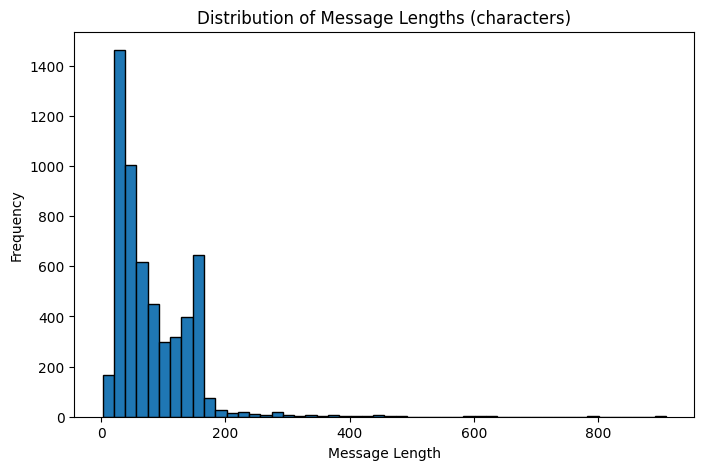

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(message_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Message Lengths (characters)")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


In [ ]:
data['Label'] = le.fit_transform(data['Label'])
#Encodes labels
#0 for Ham & 1 for Spam

In [ ]:
data.head()

,Label,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


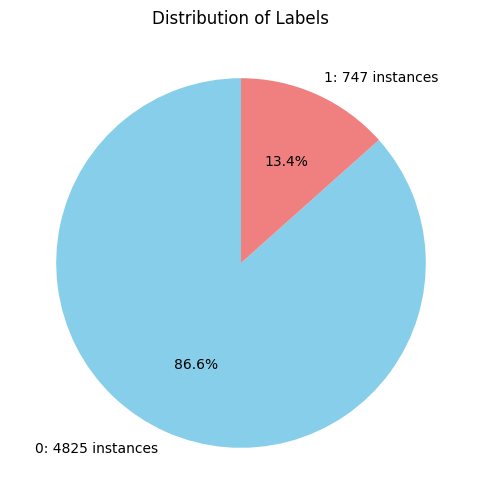

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = data['Label'].value_counts()

# Create a pie chart with percentages
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=[f'{label}: {count} instances' for label, count in label_counts.items()], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(data["Message"])
#The Tokenizer creates a vocabulary of unique words from the training data (X_train).
#Each unique word in the vocabulary is assigned a unique integer (index).
#Converts text into a numerical format that the RNN model can understand.


# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(data["Message"])
#Converts each message into a sequence of integers using the vocabulary created during tokenization.
#Words not in the vocabulary (e.g., from X_test) are ignored.
#Represents text data as numerical sequences for the RNN.

vocab_size = len(tokenizer.word_index) + 1  # Total unique words + 1 for padding token
#The size of the vocabulary (i.e., total number of unique words in the dataset) plus 1 for the padding token.

# Pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
#Ensures all sequences have the same length (max_length).
#Sequences shorter than max_length are padded with zeros at the end (padding='post').
#Sequences longer than max_length are truncated.
#RNNs require input sequences to have the same length for batch processing.



In [ ]:
from sklearn.model_selection import train_test_split
X = padded_sequences
y = data['Label']

#train vs temp (70/30 split)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

#split temp into validation and test (50/50 of 30% → 15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dict for Keras
class_weight_dict = dict(enumerate(class_weights))

# Function to count each label
def label_counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

# Print counts for each set
print("Class Weights:", class_weight_dict)
print("---------------------------------------------------")

train_counts = label_counts(y_train)
val_counts = label_counts(y_val)
test_counts = label_counts(y_test)

print("Total Instances:")
print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))
print("---------------------------------------------------")
print("Label Distributions")
print(f"Train - Ham: {train_counts.get(0,0)}, Spam: {train_counts.get(1,0)}")
print(f"Validation - Ham: {val_counts.get(0,0)}, Spam: {val_counts.get(1,0)}")
print(f"Test - Ham: {test_counts.get(0,0)}, Spam: {test_counts.get(1,0)}")


Class Weights: {0: np.float64(0.5774355937222386), 1: np.float64(3.72848948374761)}
---------------------------------------------------
Total Instances:
Train: 3900
Validation: 836
Test: 836
---------------------------------------------------
Label Distributions
Train - Ham: 3377, Spam: 523
Validation - Ham: 724, Spam: 112
Test - Ham: 724, Spam: 112


# Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dropout, Dense

bi_lstm_model = Sequential()

bi_lstm_model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
#input_dim=vocab_size tells the embedding layer how many unique words (indices) it needs to handle.

bi_lstm_model.add(SpatialDropout1D(0.2))

bi_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(64)))

bi_lstm_model.add(Dropout(0.2))

bi_lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile() function configures the model for training
#Optimizer: The optimiser adjusts the model's weights to minimize the loss function during training.
#The loss function measures the error between the predicted output and the actual target label. Used for binary classification tasks (e.g., phishing vs. safe emails). It calculates the negative log likelihood of the true class
#Metric: Defines how model performance will be evaluated during training and testing. Accuracy measures the proportion of correctly predicted labels.

In [ ]:
history = bi_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=40,
    verbose=2,
    class_weight=class_weight_dict
)

#The fit() method is used to train the model. It takes the training data and labels, along with other hyperparameters,
#and iteratively adjusts the model's internal weights to minimise the error (loss function).

#Input (X_train): The padded sequences of tokenized  text (numerical input for the RNN).

#Target (y_train): Binary labels (0 = "Safe", 1 = "Phishing").

#validation_data: The test set is used as the validation set to monitor the model's performance on unseen data during training.
#Validation helps detect overfitting by showing the gap between training and validation performance.

#epochs: Number of complete passes through the entire training dataset. In each epoch, the model processes the entire training data once

#batch_size: Number of samples processed before updating the model’s weights.
#Smaller batch sizes: Allow more frequent updates but can make training noisy.
#Larger batch sizes: Smooth updates but require more memory and computation.

#verbose: Controls the level of detail printed during training: 0: No output. 1: Progress bar. 2: Detailed output per epoch (used here).

Epoch 1/3
98/98 - 45s - 461ms/step - accuracy: 0.8887 - loss: 0.2935 - val_accuracy: 0.9856 - val_loss: 0.0641
Epoch 2/3
98/98 - 31s - 320ms/step - accuracy: 0.9882 - loss: 0.0730 - val_accuracy: 0.9294 - val_loss: 0.2481
Epoch 3/3
98/98 - 32s - 324ms/step - accuracy: 0.9946 - loss: 0.0282 - val_accuracy: 0.9785 - val_loss: 0.0641


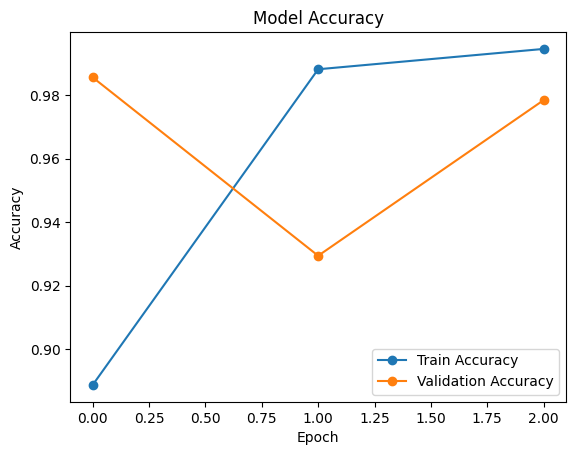

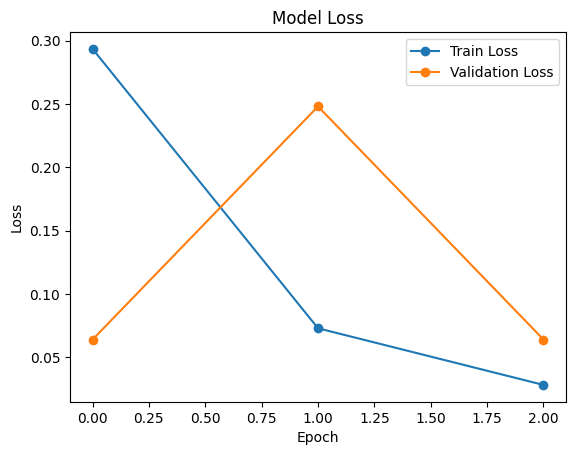

In [ ]:
# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Model Testing & Evaluation

In [ ]:
y_predictions = (bi_lstm_model.predict(X_test) > 0.5).astype(int)
# This line uses the trained neural network model to predict the class for the test dataset (`X_test`).
# `y_predictions`: Outputs a probability score (between 0 and 1) for each test sample, representing how likely it is to belong to the positive class (e.g., spam/phishing if 1, or safe if 0).
# - if the probability is greater than 0.5, it is classified as 1 (spam/phishing).
# - if the probability is less than or equal to 0.5, it is classified as 0 (safe message).

# Get predicted probabilities
y_pred_probs = bi_lstm_model.predict(X_test).ravel()



27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


Test Accuracy: 0.9833
95% Confidence Interval: [0.9721, 0.9900]
---------------------------------------------------------------
Accuracy: 0.9832535885167464
Precision: 0.9835915873801536
Recall: 0.9832535885167464
F1-Score: 0.9833772923873522
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       724
        Spam       0.92      0.96      0.94       112

    accuracy                           0.98       836
   macro avg       0.96      0.97      0.96       836
weighted avg       0.98      0.98      0.98       836



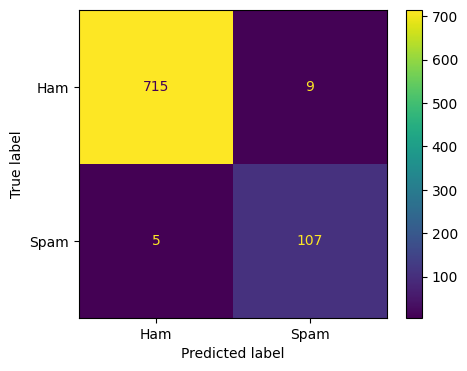

In [ ]:
from statsmodels.stats.proportion import proportion_confint


accuracy_bidirectional = metrics.accuracy_score(y_test, y_predictions)
# Calculates the accuracy of the model's predictions on the test data by comparing the predicted labels (`y_predictions`) with the actual labels (`y_test`).

precision_bidrectional = metrics.precision_score(y_test, y_predictions, average='weighted')
#Calculates the precision of the model's predictions on the test data using the method precision_score() in metrics. Precision is the ratio of true positive predictions to the total number of positive predictions made by the model.

recall_bidirectional = metrics.recall_score(y_test, y_predictions, average='weighted')
#Calculates the recall of the model's predictions on the test data's labels of test samples using the method recall_score() in metrics. Recall is the ratio of true positive predictions to the actual number of positive instances (true positives + false negatives).

f1_bidirectional = metrics.f1_score(y_test, y_predictions, average='weighted')
# Calculates the F1 score for the model's predictions on the test data's labels of test samples using the method f1_score() in metrics. The F1 score is the harmonic mean of precision and recall, providing a balanced measure that accounts for both false positives and false negatives.

# The `average='weighted'` parameter ensures that the various scores are calculated for each class and then averaged, weighted by the number of instances in each class, which is important when class sizes are imbalanced.

# Confidence interval (95%)
n = len(y_test)   # number of test samples
correct = (y_predictions.flatten() == y_test).sum()

ci_low, ci_high = proportion_confint(correct, n, alpha=0.05, method="wilson")

print(f"Test Accuracy: {accuracy_bidirectional:.4f}")
print(f"95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

print ("---------------------------------------------------------------")

report_bidirectional = metrics.classification_report(y_test, y_predictions, target_names=['Ham', 'Spam'])
print(f"Accuracy: {accuracy_bidirectional}")
print(f"Precision: {precision_bidrectional}")
print(f"Recall: {recall_bidirectional}")
print(f"F1-Score: {f1_bidirectional}")
print(report_bidirectional)

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = metrics.confusion_matrix(y_test, y_predictions)
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels = ['Ham', 'Spam'])
cmp.plot(ax = ax);

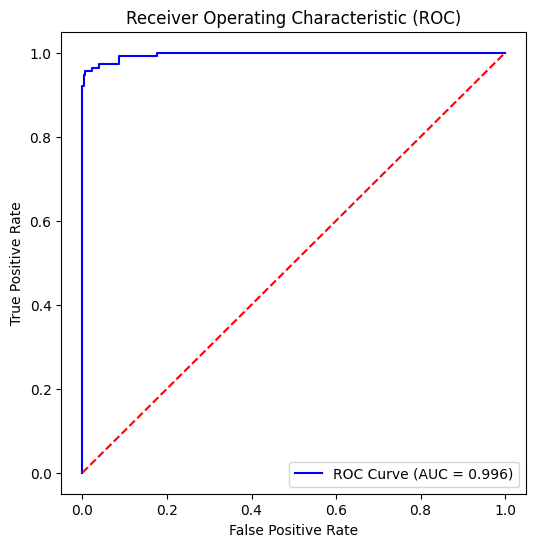

In [ ]:
from sklearn.metrics import roc_curve, auc
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

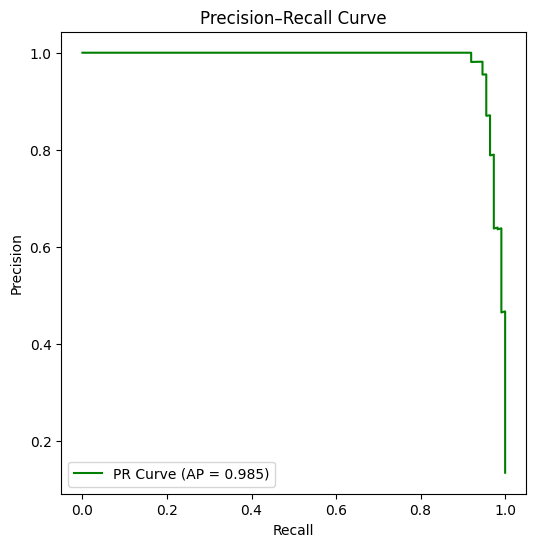

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
ap_score = average_precision_score(y_test, y_pred_probs)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {ap_score:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


# LSTM Model

In [ ]:
# LSTM model
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=vocab_size, output_dim=128))

# Dropout for regularisation
lstm_model.add(SpatialDropout1D(0.2))

# LSTM layer
lstm_model.add(LSTM(64, return_sequences=True))  # no bidirectional wrapper
lstm_model.add(LSTM(64))

# Dropout for regularisation
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

LSTM_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=40,
    verbose=2,
    class_weight=class_weight_dict
)

Epoch 1/3
98/98 - 19s - 195ms/step - accuracy: 0.5826 - loss: 0.6945 - val_accuracy: 0.8648 - val_loss: 0.6914
Epoch 2/3
98/98 - 17s - 169ms/step - accuracy: 0.4526 - loss: 0.6943 - val_accuracy: 0.1340 - val_loss: 0.6962
Epoch 3/3
98/98 - 16s - 164ms/step - accuracy: 0.3323 - loss: 0.6939 - val_accuracy: 0.1340 - val_loss: 0.7042


In [ ]:
LSTM_y_predictions = (lstm_model.predict(X_test) > 0.5).astype(int)


# Get predicted probabilities
LSTM_y_pred_probs = lstm_model.predict(X_test).ravel()

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Test Accuracy: 0.1340
95% Confidence Interval: [0.1125, 0.1587]
---------------------------------------------------------------
Accuracy: 0.1339712918660287
Precision: 0.01794830704425265
Recall: 0.1339712918660287
F1-Score: 0.03165566390083379
              precision    recall  f1-score   support

         Ham       0.00      0.00      0.00       724
        Spam       0.13      1.00      0.24       112

    accuracy                           0.13       836
   macro avg       0.07      0.50      0.12       836
weighted avg       0.02      0.13      0.03       836



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

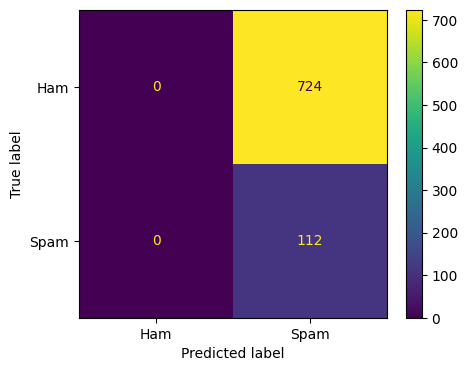

In [ ]:
LSTM_accuracy = metrics.accuracy_score(y_test, LSTM_y_predictions)

LSTM_precision = metrics.precision_score(y_test, LSTM_y_predictions, average='weighted')

LSTM_recall = metrics.recall_score(y_test, LSTM_y_predictions, average='weighted')

LSTM_f1 = metrics.f1_score(y_test, LSTM_y_predictions, average='weighted')


n = len(y_test)
correct = (LSTM_y_predictions.flatten() == y_test).sum()

LSTM_ci_low, LSTM_ci_high = proportion_confint(correct, n, alpha=0.05, method="wilson")

print(f"Test Accuracy: {LSTM_accuracy:.4f}")
print(f"95% Confidence Interval: [{LSTM_ci_low:.4f}, {LSTM_ci_high:.4f}]")

print ("---------------------------------------------------------------")

LSTM_report = metrics.classification_report(y_test, LSTM_y_predictions, target_names=['Ham', 'Spam'])
print(f"Accuracy: {LSTM_accuracy}")
print(f"Precision: {LSTM_precision}")
print(f"Recall: {LSTM_recall}")
print(f"F1-Score: {LSTM_f1}")
print(LSTM_report)

fig,ax = plt.subplots(figsize=(5,4),dpi = 100)
cm = metrics.confusion_matrix(y_test, LSTM_y_predictions)
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels = ['Ham', 'Spam'])
cmp.plot(ax = ax);

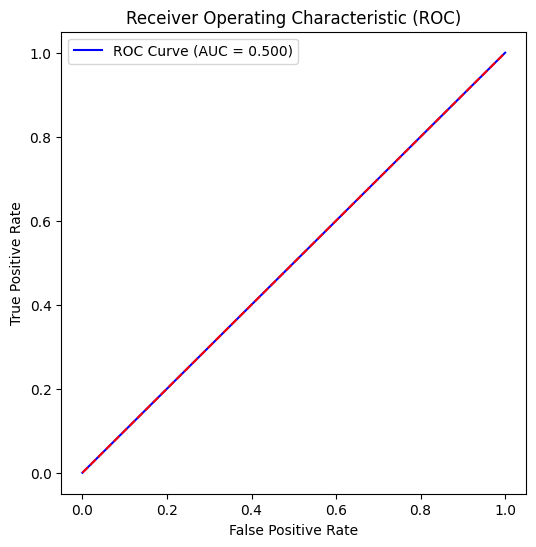

In [ ]:
LSTM_fpr, LSTM_tpr, LSTM_thresholds = roc_curve(y_test, LSTM_y_pred_probs)
LSTM_roc_auc = auc(LSTM_fpr, LSTM_tpr)

plt.figure(figsize=(6,6))
plt.plot(LSTM_fpr, LSTM_tpr, color='blue', label=f'ROC Curve (AUC = {LSTM_roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

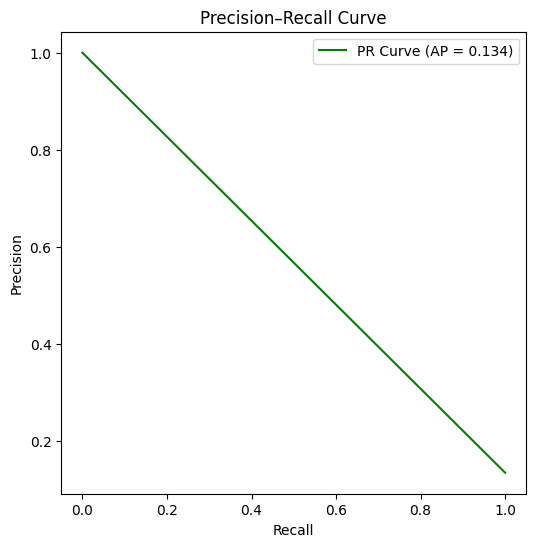

In [ ]:
LSTM_precision, LSTM_recall, LSTM_thresholds = precision_recall_curve(y_test, LSTM_y_pred_probs)
LSTM_ap_score = average_precision_score(y_test, LSTM_y_pred_probs)

plt.figure(figsize=(6,6))
plt.plot(LSTM_recall, LSTM_precision, color='green', label=f'PR Curve (AP = {LSTM_ap_score:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()